In [1]:
# Install any packages not already available in Kaggle
!pip install nibabel split-folders tifffile


In [2]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import splitfolders  # For splitting the dataset into training and validation

# Initialize the scaler
scaler = MinMaxScaler()

# Kaggle-specific dataset paths
TRAIN_DATASET_PATH = '/kaggle/input/brats2019/BraTS 2020/BraTS 2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'


1854.603271484375
[0 1 2 4]
[0 1 2 3]


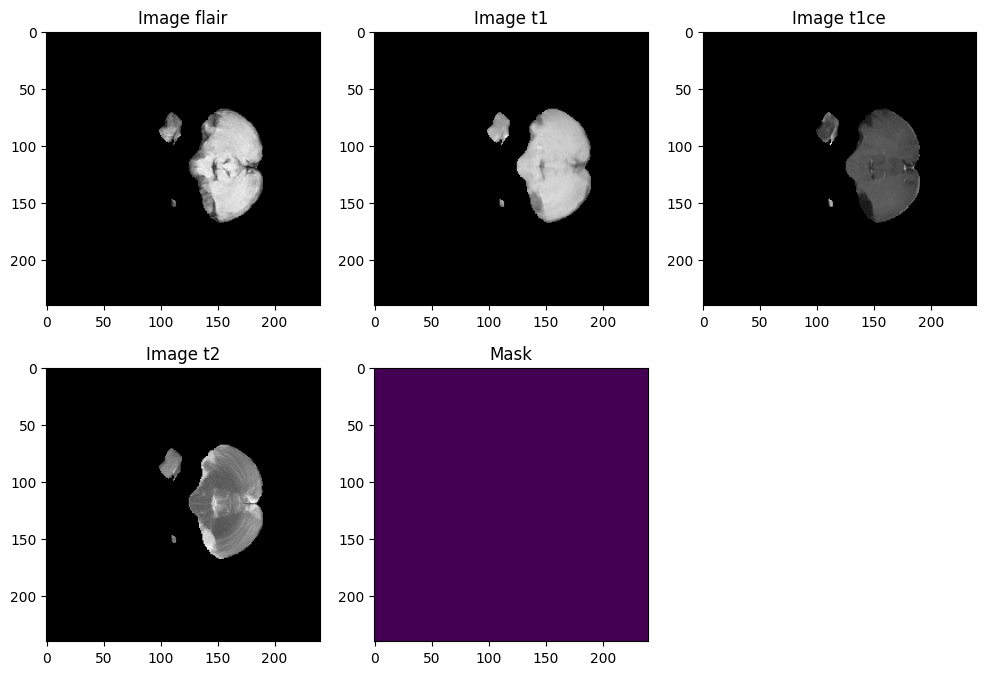

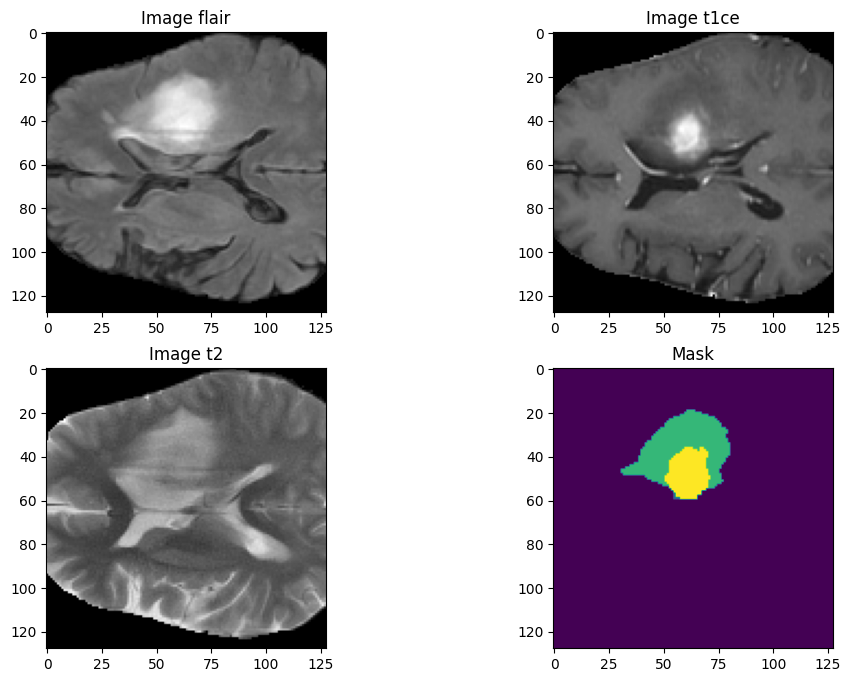

In [3]:

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

test_mask = to_categorical(test_mask, num_classes=4)

In [4]:
import os
import numpy as np
import nibabel as nib
from skimage import img_as_ubyte
from skimage.io import imsave
from sklearn.preprocessing import MinMaxScaler
import glob
from keras.utils import to_categorical  # Importing to_categorical for mask processing

# Paths
TRAIN_DATASET_PATH = '/kaggle/input/brats2019/BraTS 2020/BraTS 2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
output_dir = '/kaggle/working/brats_output/'

# Create directories for combined images and masks
combined_image_dir = os.path.join(output_dir, 'combined_images')
mask_dir = os.path.join(output_dir, 'masks')
os.makedirs(combined_image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Load and preprocess functions
scaler = MinMaxScaler()

# Get lists of image file paths
t2_list = sorted(glob.glob(os.path.join(TRAIN_DATASET_PATH, '*/*t2.nii')))
t1ce_list = sorted(glob.glob(os.path.join(TRAIN_DATASET_PATH, '*/*t1ce.nii')))
flair_list = sorted(glob.glob(os.path.join(TRAIN_DATASET_PATH, '*/*flair.nii')))
mask_list = sorted(glob.glob(os.path.join(TRAIN_DATASET_PATH, '*/*seg.nii')))

# Process each volume
for img in range(len(t2_list)):
    print("Now preparing image and masks number: ", img)

    # Load images and preprocess
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values 4 to 3

    # Combine images into a single array
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop to a size divisible by 64
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0] / counts.sum())) > 0.01:  # At least 1% useful volume
        print("Save Me")
        
        # Convert mask to categorical
        temp_mask = to_categorical(temp_mask, num_classes=4)

        # Compress and save the combined images and masks
        np.savez_compressed(os.path.join(combined_image_dir, f"{img}.npz"), images=temp_combined_images)
        np.savez_compressed(os.path.join(mask_dir, f"{img}.npz"), masks=temp_mask)

    else:
        print("Not enough data to process")


Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
Not enough data to process
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19

In [5]:
''''
import os
import shutil

# Specify the working directory
working_dir = '/kaggle/working/'

# Remove all files and folders in the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)
    '''


"'\nimport os\nimport shutil\n\n# Specify the working directory\nworking_dir = '/kaggle/working/'\n\n# Remove all files and folders in the working directory\nfor filename in os.listdir(working_dir):\n    file_path = os.path.join(working_dir, filename)\n    if os.path.isfile(file_path):\n        os.remove(file_path)\n    elif os.path.isdir(file_path):\n        shutil.rmtree(file_path)\n    "

In [6]:
print("Shape of test_mask:", test_mask.shape)


Shape of test_mask: (128, 128, 128, 4)


In [7]:
split_output_dir = '/kaggle/working/brats_output_split/'

# Organize by ratio (e.g., 75% training, 25% validation)
splitfolders.ratio(
    output_dir,  # Path with `combined_images` and `masks` subfolders
    output=split_output_dir, 
    seed=42, 
    ratio=(.75, .25),  # Adjust as needed
    group_prefix=None  # Ensures images and masks stay matched
)

Copying files: 688 files [00:31, 22.03 files/s] 


In [8]:
import numpy as np

# Change this to one of your npz files to check its content
example_file = '/kaggle/working/brats_output_split/train/combined_images/58.npz'
data = np.load(example_file)

# List all keys in the npz file
print(data.files)

['images']


Shape of test_mask: (128, 128, 128)


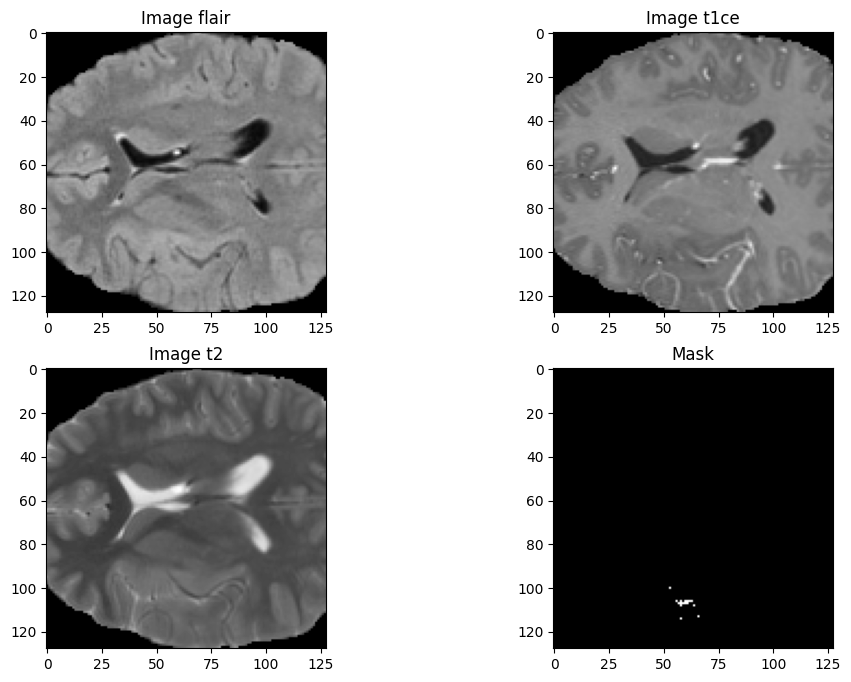

In [9]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random

def load_img(img_dir, img_list, expected_key):
    images = []
    for image_name in img_list:
        if image_name.endswith('.npz'):
            # Load the .npz file
            data = np.load(os.path.join(img_dir, image_name))
            #print(f"Contents of {image_name}: {data.files}")
            
            # Access the appropriate array based on the expected key
            if expected_key in data:
                image = data[expected_key].astype(np.float32)  # Convert to float32
            else:
                raise KeyError(f"{expected_key} is not a file in the archive for {image_name}")
            
            images.append(image)
    images = np.array(images)
    return images

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)

    # Infinite generator
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            # Pass the expected keys for images and masks
            X = load_img(img_dir, img_list[batch_start:limit], 'images')
            Y = load_img(mask_dir, mask_list[batch_start:limit], 'masks')

            yield (X, Y)  # A tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size
            batch_end += batch_size

############################################

# Test the generator
train_img_dir = "/kaggle/working/brats_output_split/train/combined_images/"
train_mask_dir = "/kaggle/working/brats_output_split/train/masks/"
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                 train_mask_dir, train_mask_list, batch_size)

# Verify generator
img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]

# If masks are categorical, ensure to use the right axis
if test_mask.ndim == 3:  # Assuming mask is 3D (width, height, classes)
    test_mask = np.argmax(test_mask, axis=-1)
elif test_mask.ndim == 4:  # Assuming mask is 4D (width, height, num_classes)
    # Select one class to visualize; modify this as necessary
    test_mask = np.argmax(test_mask, axis=-1)  # Convert to 3D by selecting the class with the highest probability

print("Shape of test_mask:", test_mask.shape)

# Select a slice based on the number of dimensions
'''
if test_mask.ndim == 3 or test_mask.ndim == 4:
    n_slice = random.randint(0, test_mask.shape[2] - 1)  # Using the third dimension
elif test_mask.ndim == 2:
    n_slice = 0  # Use the only slice available or handle it
'''
plt.figure(figsize=(12, 8))

# Ensure that the dimensions match
if test_img.ndim == 4:
    plt.subplot(221)
    plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')
    plt.title('Image flair')

    plt.subplot(222)
    plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')
    plt.title('Image t1ce')

    plt.subplot(223)
    plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')
    plt.title('Image t2')

    plt.subplot(224)
    plt.imshow(test_mask[:, :, n_slice], cmap='gray')
    plt.title('Mask')
else:
    plt.subplot(121)
    plt.imshow(test_img, cmap='gray')
    plt.title('Image')

    plt.subplot(122)
    plt.imshow(test_mask, cmap='gray')
    plt.title('Mask')

plt.show()


In [10]:
print("Shape of test_mask:", test_mask.shape)


Shape of test_mask: (128, 128, 128)


In [11]:
!pip install sm
!pip install segmentation-models-3D

import os
import numpy as np

import keras
from matplotlib import pyplot as plt
import glob
import random
import pandas as pd
from keras.models import load_model
from keras.metrics import MeanIoU
import segmentation_models_3D as sm


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for sm: filename=sm-0.1.8-py3-none-any.whl size=4725 sha256=a02070b7eee92764118e9237b32c3d17b0bae8f1831dd4dd91c07778548bbfa5
  Stored in directory: /root/.cache/pip/wheels/2a/6c/33/c5ad950b724d92bfde5fbfe80ca1dcbb35d591e54174ef24c3
Successfully built sm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.6 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


In [12]:
import pandas as pd
import numpy as np
import glob

columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/kaggle/working/brats_output_split/train/masks/*.npz'))

# Loop through each image and collect label counts
for img in range(len(train_mask_list)):
    
    temp_image = np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=0)
    val, counts = np.unique(temp_image, return_counts=True)
    
    # Creating a dictionary for the counts and adding it as a new row to the DataFrame
    conts_dict = dict(zip(columns, counts))
    new_row = pd.DataFrame([conts_dict], columns=columns)
    df = pd.concat([df, new_row], ignore_index=True)

# Calculate label sums
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

# Calculate class weights with zero check
def calculate_weight(total_labels, n_classes, label_count):
    return round((total_labels / (n_classes * label_count)), 2) if label_count > 0 else 0

wt0 = calculate_weight(total_labels, n_classes, label_0)
wt1 = calculate_weight(total_labels, n_classes, label_1)
wt2 = calculate_weight(total_labels, n_classes, label_2)
wt3 = calculate_weight(total_labels, n_classes, label_3)
wt1,wt2,wt3=0.25,0.25,0.25
# Output the class weights
print("\n")
print("Class weights:")
print(f"Class 0 weight: {wt0}")
print(f"Class 1 weight: {wt1}")
print(f"Class 2 weight: {wt2}")
print(f"Class 3 weight: {wt3}")




Class weights:
Class 0 weight: 0.25
Class 1 weight: 0.25
Class 2 weight: 0.25
Class 3 weight: 0.25


In [13]:
train_img_dir = "/kaggle/working/brats_output_split/train/combined_images/"
train_mask_dir = "/kaggle/working/brats_output_split/train/masks/"
val_img_dir = "/kaggle/working/brats_output_split/val/combined_images/"
val_mask_dir = "/kaggle/working/brats_output_split/val/masks/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
print(len(train_img_list),len(train_mask_list))
print(len(val_img_list),len(val_mask_list))

258 258
86 86


In [14]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()


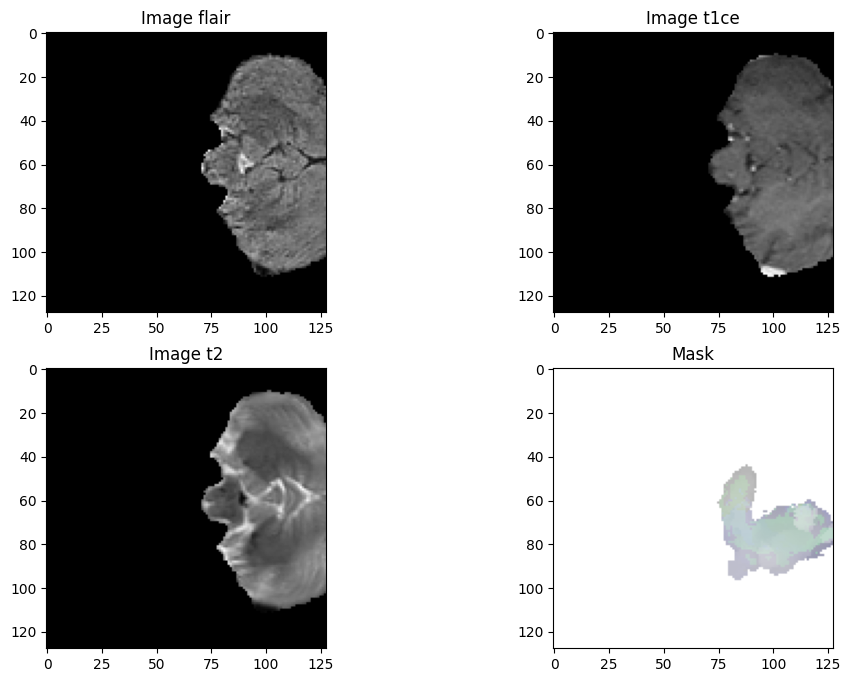

In [15]:
img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = np.argmax(msk[img_num], axis=2)
n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask)
plt.title('Mask')
plt.show()


In [16]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.000001
optim = keras.optimizers.Adam(LR)


In [17]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose, BatchNormalization, concatenate, Activation

def nnunet_3d(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    def conv_block(input, filters):
        x = Conv3D(filters, (3, 3, 3), padding='same')(input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv3D(filters, (3, 3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(input, filters):
        x = conv_block(input, filters)
        p = MaxPooling3D((2, 2, 2))(x)
        return x, p

    def decoder_block(input, skip_features, filters):
        x = Conv3DTranspose(filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(input)
        x = concatenate([x, skip_features])
        x = conv_block(x, filters)
        return x

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output layer
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(d4)

    model = Model(inputs, outputs)
    model.summary()
    return model


In [18]:
from keras.optimizers import Adam
from keras.backend import clear_session

# Step 1: Clear the session to avoid any conflicts
clear_session()

# Step 2: Recreate the model
model = nnunet_3d(128, 128, 128, 3, 4)  # Correct input dimensions and output classes

# Step 3: Reinitialize the optimizer
optimizer = Adam(learning_rate=0.001)

# Step 4: Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
)

# Step 6: Save the model
model.save('brats_nnunet_3d.hdf5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      2,624 │ input_layer[0][0] │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │     27,680 │ activation[0][0]  │
│                     │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling3D)      │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │    110,656 │ activation_2[0][… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d_1[… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_4[0][0]  

 Total params: 22,588,932 (86.17 MB)

 Trainable params: 22,583,044 (86.15 MB)

 Non-trainable params: 5,888 (23.00 KB)

Epoch 1/10


I0000 00:00:1731772719.006506     135 service.cc:145] XLA service 0x7ff1300118f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731772719.007494     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731772719.007503     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-16 15:58:44.045917: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[2,32,128,128,128]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,128,128,128]{4,3,2,1,0}, f32[32,32,3,3,3]{4,3,2,1,0}, f32[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-

129/129 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.7678 - loss: 0.8190 - val_accuracy: 0.9504 - val_loss: 0.3812
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9575 - loss: 0.1980 - val_accuracy: 0.9294 - val_loss: 0.2499
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.9617 - loss: 0.1340 - val_accuracy: 0.9227 - val_loss: 0.2422
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9642 - loss: 0.1108 - val_accuracy: 0.9588 - val_loss: 0.1195
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9664 - loss: 0.0997 - val_accuracy: 0.9140 - val_loss: 0.2455
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9674 - loss: 0.0944 - val_accuracy: 0.9456 - val_loss: 0.2588
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9675 - loss: 0.0914 - val_accuracy: 0.9256 - val_loss: 0.2066
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.9685 - loss: 0.0869 - val_accuracy: 0.926

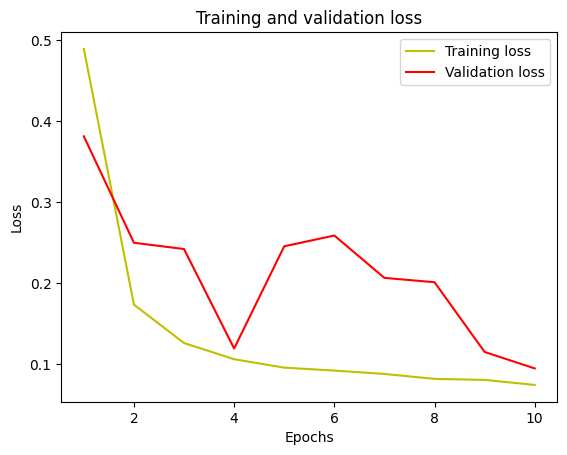

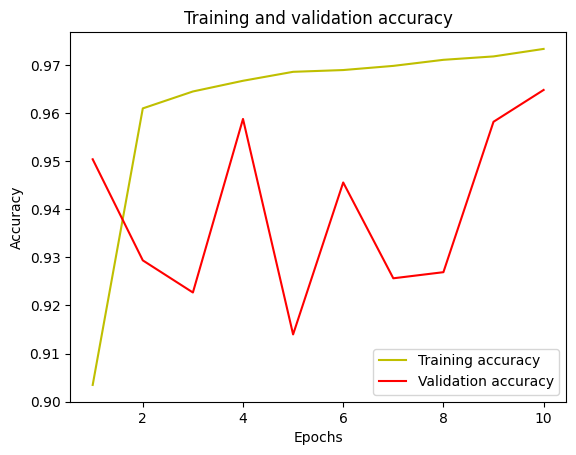

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice loss for segmentation."""
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice, axis=0)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    """Focal loss for handling class imbalance."""
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    return tf.reduce_sum(weight * cross_entropy, axis=[1, 2, 3])

def iou_loss(y_true, y_pred, smooth=1e-6):
    """IoU loss for segmentation."""
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(tf.abs(y_true), axis=[1, 2, 3]) + tf.reduce_sum(tf.abs(y_pred), axis=[1, 2, 3]) + smooth
    iou = intersection / union
    return 1 - tf.reduce_mean(iou, axis=0)

def combined_loss(y_true, y_pred):
    """Combined Dice Loss + Focal Loss + IoU Loss."""
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss(y_true, y_pred)
    iou = iou_loss(y_true, y_pred)
    
    return dice + focal + iou



In [36]:
from keras.models import load_model

# Load model with custom objects
my_model = load_model('/kaggle/working/brats_nnunet_3d.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss, 
                                      'iou_score': iou_score})


In [72]:
from keras.models import load_model

# Load model with custom objects
my_model = load_model('/kaggle/working/brats_nnunet_3d.hdf5', 
                      custom_objects={'dice_loss': dice_loss, 
                                      'focal_loss': focal_loss, 
                                      'iou_loss': iou_loss, 
                                      'combined_loss': combined_loss, 
                                      'iou_score': iou_score})

# Recompile the model with the new loss function and metrics
my_model.compile(optimizer='adam', 
                 loss=combined_loss,  # Use the new combined loss
                 metrics=['accuracy', iou_score])  # Keeping iou_score as a metric


In [73]:
# Validation data loader function
def load_validation_data(img_dir, img_list, mask_dir, mask_list):
    # Load all validation images
    X_val = load_img(img_dir, img_list, 'images')
    Y_val = load_img(mask_dir, mask_list, 'masks')
    return X_val, Y_val

# Validation directories
val_img_dir = "/kaggle/working/brats_output_split/val/combined_images/"
val_mask_dir = "/kaggle/working/brats_output_split/val/masks/"
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

# Load validation data
X_val, Y_val = load_validation_data(val_img_dir, val_img_list, val_mask_dir, val_mask_list)

print(f"Validation Images Shape: {X_val.shape}")
print(f"Validation Masks Shape: {Y_val.shape}")


Validation Images Shape: (86, 128, 128, 128, 3)
Validation Masks Shape: (86, 128, 128, 128, 4)


In [74]:
# Perform validation

results = my_model.evaluate(X_val, Y_val, batch_size=2, verbose=1)
print(f"Validation Loss: {results[0]}")
print(f"Validation Metrics: {results[1:]}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9630 - iou_score: 0.2431 - loss: 7717.0166
Validation Loss: 7484.0224609375
Validation Metrics: [0.9648095965385437, 0.24053174257278442]


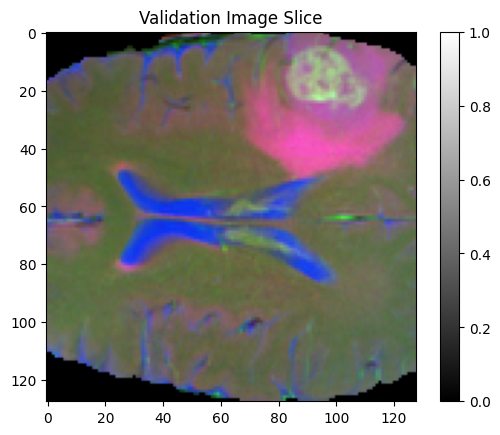

In [75]:
slice_idx = 64  # Example: middle slice
plt.imshow(val_img_sample[:, :, slice_idx], cmap='gray')
plt.title("Validation Image Slice")
plt.colorbar()
plt.show()


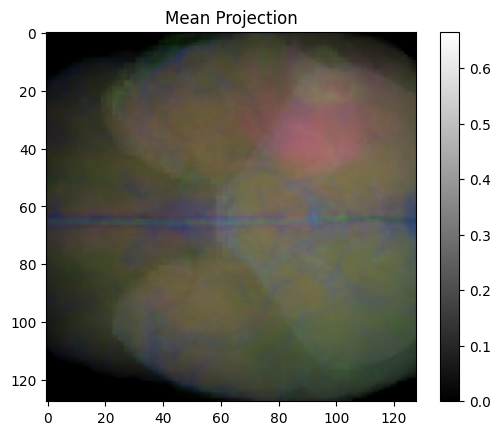

(128, 128, 128, 3)


In [76]:
# Mean projection
projection = val_img_sample.mean(axis=2)
plt.imshow(projection, cmap='gray')
plt.title("Mean Projection")
plt.colorbar()
plt.show()
print(val_img_sample.shape)  # Ensure expected dimensions


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


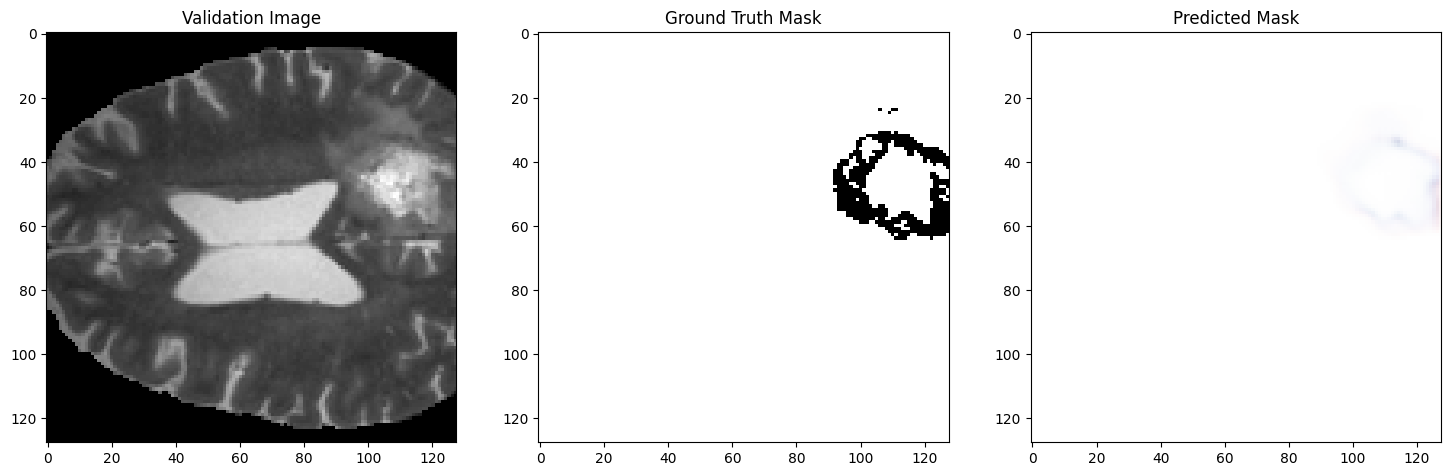

In [77]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick a random sample from the validation set
val_index = random.randint(0, X_val.shape[0] - 1)
val_img_sample = X_val[val_index]  # Shape: (128, 128, 128, 3) or similar
val_mask_sample = Y_val[val_index]  # Shape: (128, 128, 128)

# Predict mask
predicted_mask = my_model.predict(val_img_sample[np.newaxis, ...])[0]  # Shape: (128, 128, 128, num_classes)

# If masks are categorical, convert to class indices
if predicted_mask.ndim == 3:
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert to class indices
if val_mask_sample.ndim == 3:
    val_mask_sample = np.argmax(val_mask_sample, axis=-1)  # Convert to class indices

# Pick a random slice (e.g., the middle slice, or choose a random one)
n_slice = random.randint(0, val_img_sample.shape[2] - 1)  # Random slice index

# Visualize
plt.figure(figsize=(18, 6))

# Plot the input image slice (e.g., channel 0 for 'flair' or other modality)
plt.subplot(131)
plt.imshow(val_img_sample[:, :, n_slice, 2], cmap='gray')  # Assuming the image has 3 channels
plt.title("Validation Image")

# Plot the ground truth mask for the chosen slice
plt.subplot(132)
plt.imshow(val_mask_sample[:, :, n_slice], cmap='gray')
plt.title("Ground Truth Mask")

# Plot the predicted mask for the chosen slice
plt.subplot(133)
plt.imshow(predicted_mask[:, :, n_slice], cmap='gray')
plt.title("Predicted Mask")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


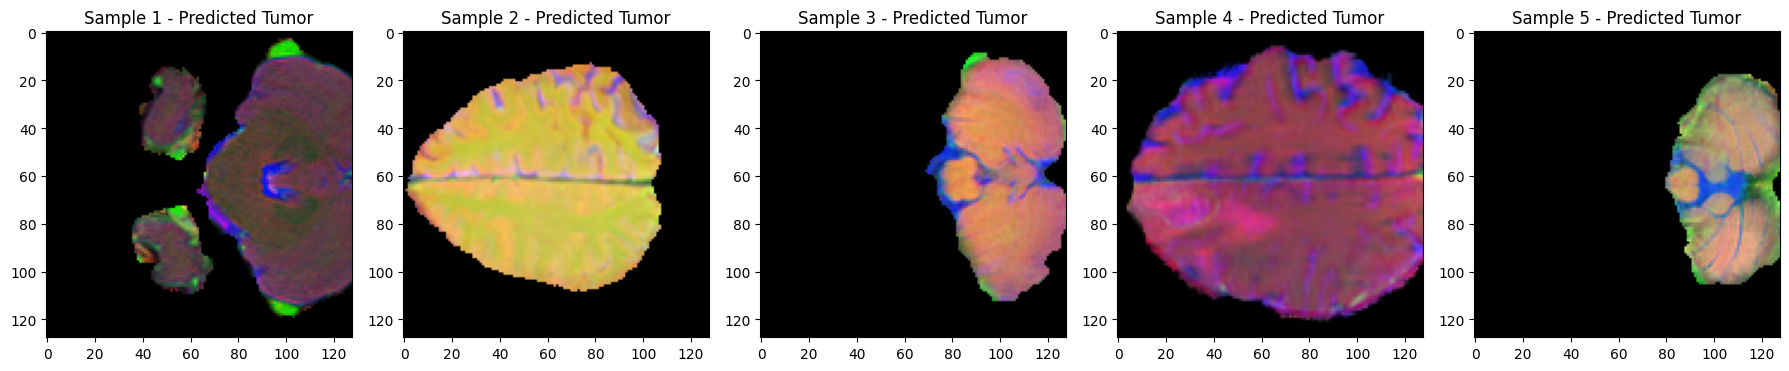

In [85]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Number of samples to visualize
num_samples = 5

# Create a figure with subplots for 10 samples (2 rows, 5 columns)
plt.figure(figsize=(18, 10))

for i in range(num_samples):
    # Pick a random sample from the validation set
    val_index = random.randint(0, X_val.shape[0] - 1)
    val_img_sample = X_val[val_index]  # Shape: (128, 128, 128, 3) or similar
    val_mask_sample = Y_val[val_index]  # Shape: (128, 128, 128)

    # Predict mask
    predicted_mask = my_model.predict(val_img_sample[np.newaxis, ...])[0]  # Shape: (128, 128, 128, num_classes)

    # If masks are categorical, convert to class indices
    if predicted_mask.ndim == 3:
        predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert to class indices
    if val_mask_sample.ndim == 3:
        val_mask_sample = np.argmax(val_mask_sample, axis=-1)  # Convert to class indices

    # Pick a random slice (e.g., the middle slice, or choose a random one)
    n_slice = random.randint(0, val_img_sample.shape[2] - 1)  # Random slice index

    # Create binary mask for tumor (assuming tumor class is '1')
    tumor_mask_predicted = np.where(predicted_mask[:, :, n_slice] == 1, 1, 0)  # Tumor area = 1
    tumor_mask_gt = np.where(val_mask_sample[:, :, n_slice] == 1, 1, 0)  # Tumor area = 1 (Ground Truth)

    # Create the white background image to overlay the tumor
    background = np.ones_like(val_img_sample[:, :, n_slice])  # White background (1s)

    # Plot each sample (image, ground truth, predicted mask)
    plt.subplot(num_samples // 5, 5, i + 1)  # Arrange subplots in 2 rows and 5 columns

    # Plot the input image slice (e.g., channel 0 for 'flair' or other modality)
    plt.imshow(val_img_sample[:, :, n_slice], cmap='gray')  # Assuming the image has 3 channels
    plt.title(f"Sample {i + 1} - Image")

    # Plot the ground truth tumor mask with a white background
    plt.imshow(tumor_mask_gt, cmap='gray', alpha=0.5)  # Tumor in gray (for visibility)
    plt.title(f"Sample {i + 1} - Ground Truth Tumor")

    # Plot the predicted tumor mask with a white background
    plt.imshow(tumor_mask_predicted, cmap='jet', alpha=0.7)  # Tumor in jet colormap
    plt.title(f"Sample {i + 1} - Predicted Tumor")

plt.tight_layout()  # To avoid overlap in titles
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


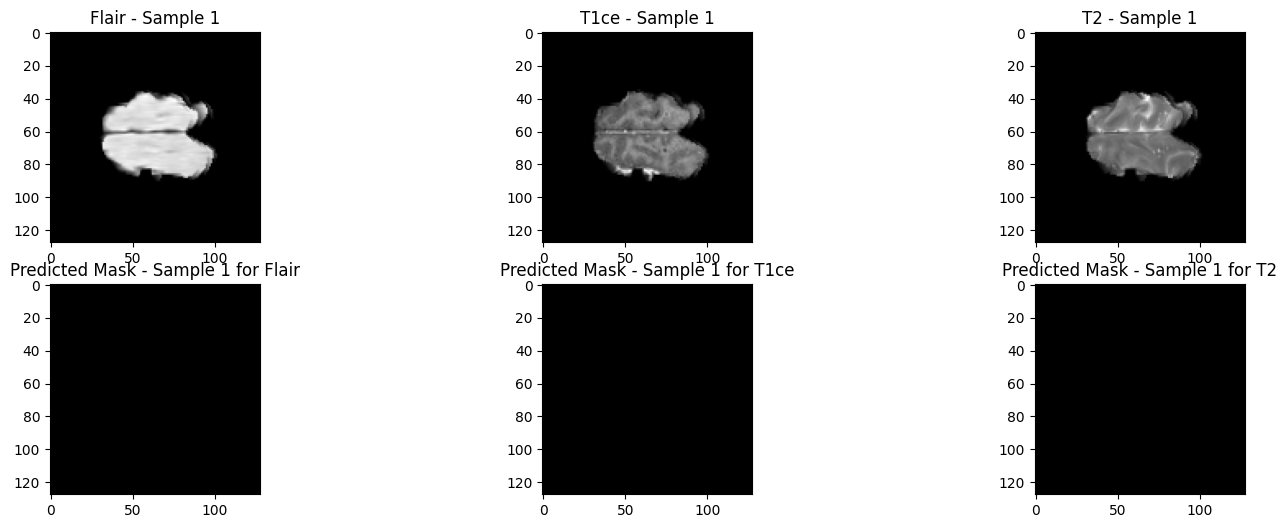

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


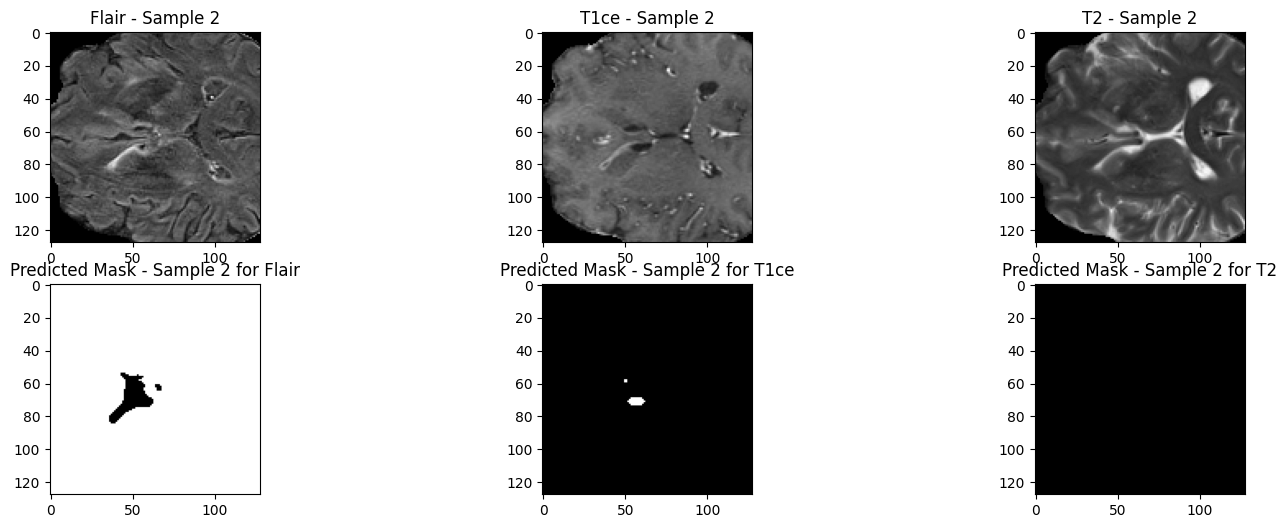

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


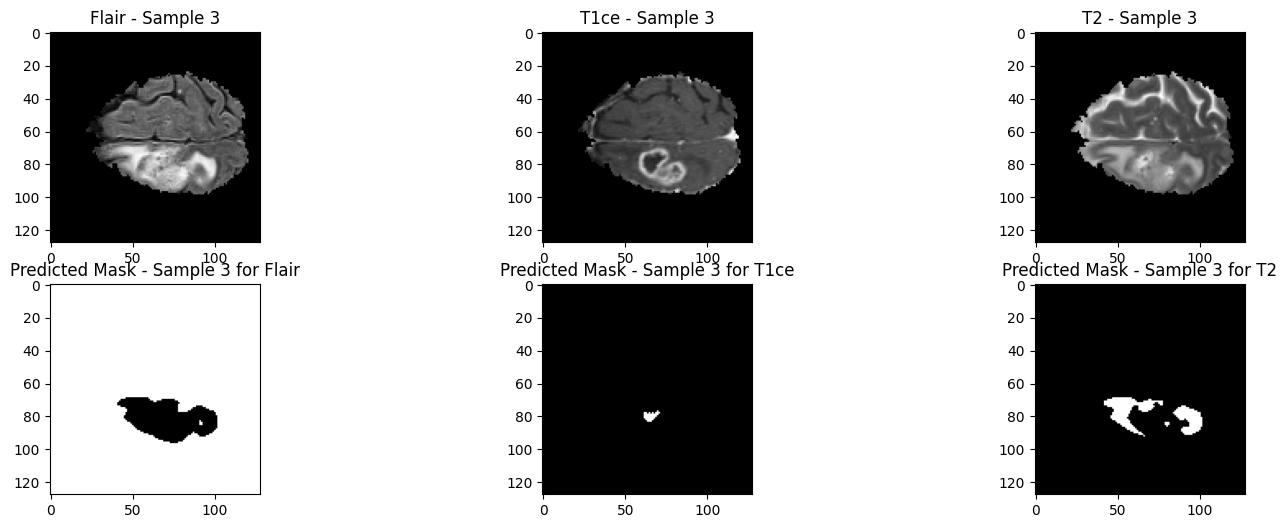

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


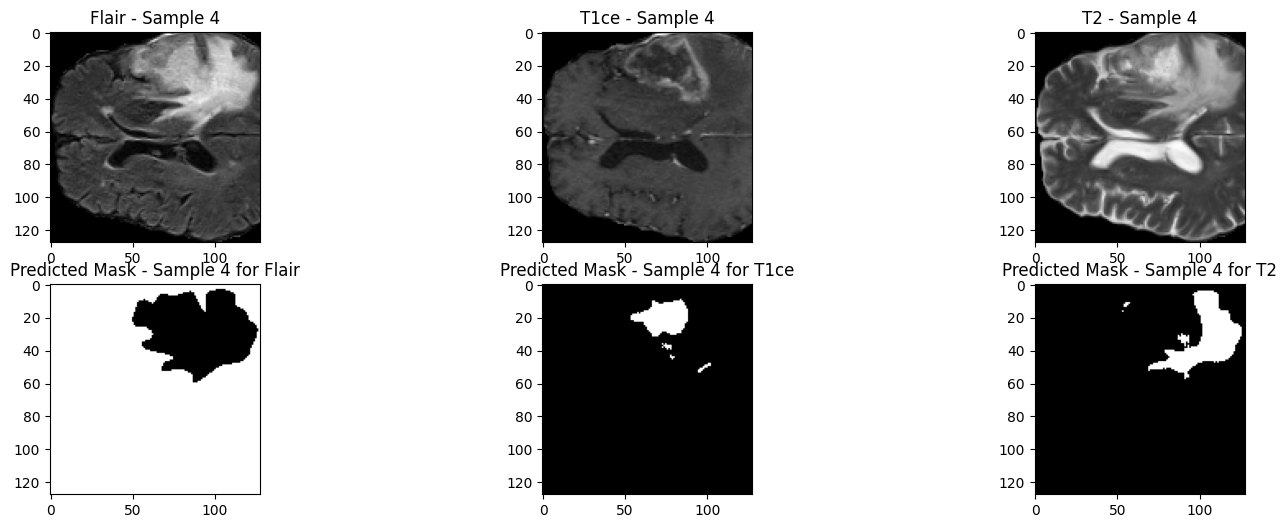

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


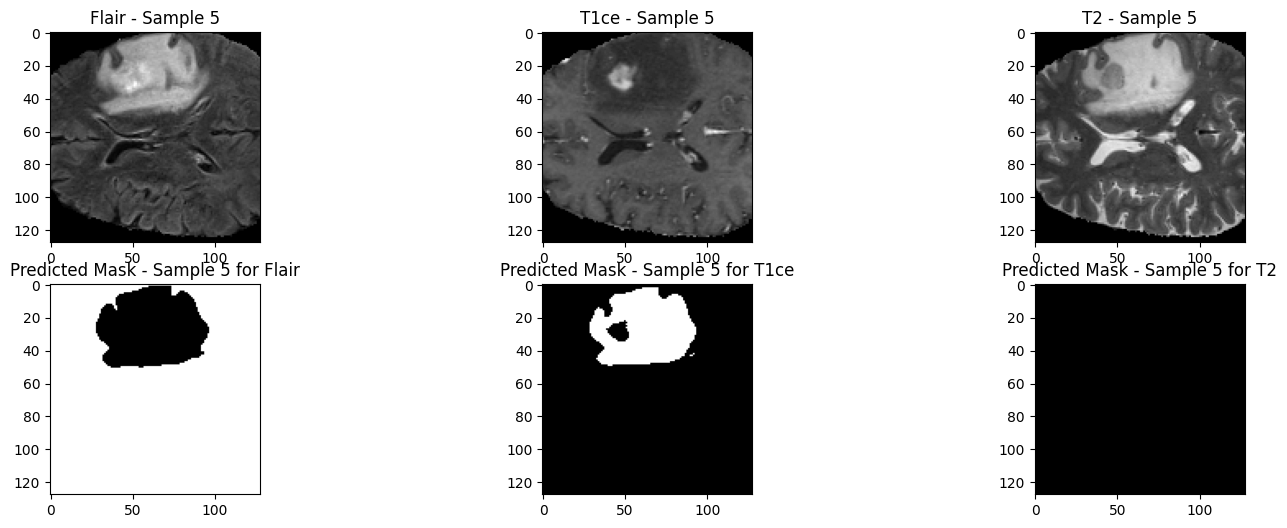

In [79]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening


# Number of samples to display
num_samples = 5

# Loop over 2 random samples
for i in range(num_samples):
    # Pick a random sample from the validation set
    val_index = random.randint(0, X_val.shape[0] - 1)
    val_img_sample = X_val[val_index]  # Shape: (128, 128, 128, 3) or similar
    val_mask_sample = Y_val[val_index]  # Shape: (128, 128, 128)

    # Predict mask
    predicted_mask = my_model.predict(val_img_sample[np.newaxis, ...])[0]  # Shape: (128, 128, 128, num_classes)
    # Thresholding predicted probabilities to binary mask (assuming sigmoid output)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Tumor vs Background

    # If masks are categorical, convert to class indices
    if predicted_mask.ndim == 3:
        predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert to class indices
    if val_mask_sample.ndim == 3:
        val_mask_sample = np.argmax(val_mask_sample, axis=-1)  # Convert to class indices

    # Pick a random slice (e.g., the middle slice, or choose a random one)
    n_slice = random.randint(0, val_img_sample.shape[2] - 1)  # Random slice index

    # Create a figure for each random sample
    plt.figure(figsize=(18, 6))

    # Plot the input image slices for different modalities
    plt.subplot(2, 3, 1)
    plt.imshow(val_img_sample[:, :, n_slice, 0], cmap='gray')  # Flair
    plt.title(f"Flair - Sample {i+1}")

    plt.subplot(2, 3, 2)
    plt.imshow(val_img_sample[:, :, n_slice, 1], cmap='gray')  # T1ce
    plt.title(f"T1ce - Sample {i+1}")

    plt.subplot(2, 3, 3)
    plt.imshow(val_img_sample[:, :, n_slice, 2], cmap='gray')  # T2
    plt.title(f"T2 - Sample {i+1}")

    plt.subplot(2, 3, 4)
    plt.imshow(predicted_mask[:, :, n_slice,0], cmap='gray')  # Predicted Mask
    plt.title(f"Predicted Mask - Sample {i+1} for Flair")
    
    plt.subplot(2, 3, 5)
    plt.imshow(predicted_mask[:, :, n_slice,1], cmap='gray')  # Predicted Mask
    plt.title(f"Predicted Mask - Sample {i+1} for T1ce")
    
    plt.subplot(2, 3, 6)
    plt.imshow(predicted_mask[:, :, n_slice,2], cmap='gray')  # Predicted Mask
    plt.title(f"Predicted Mask - Sample {i+1} for T2")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


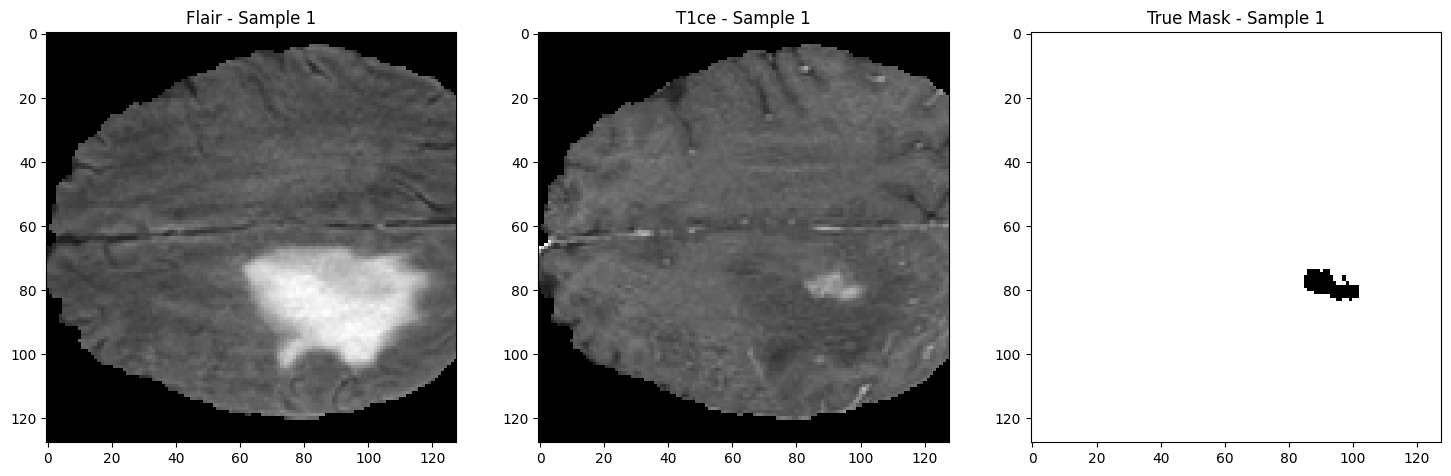

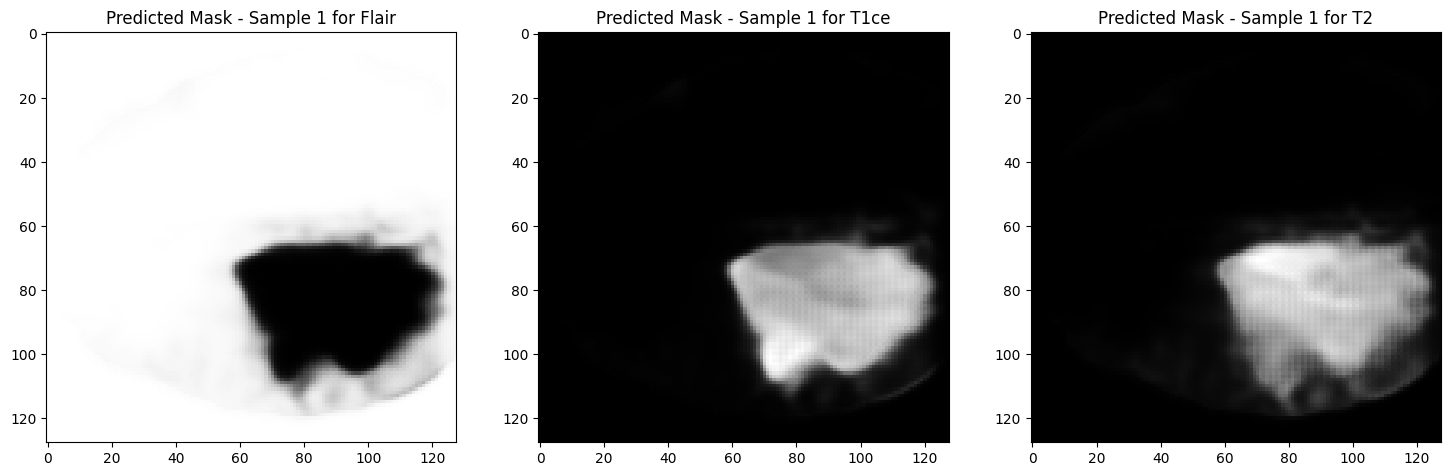

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


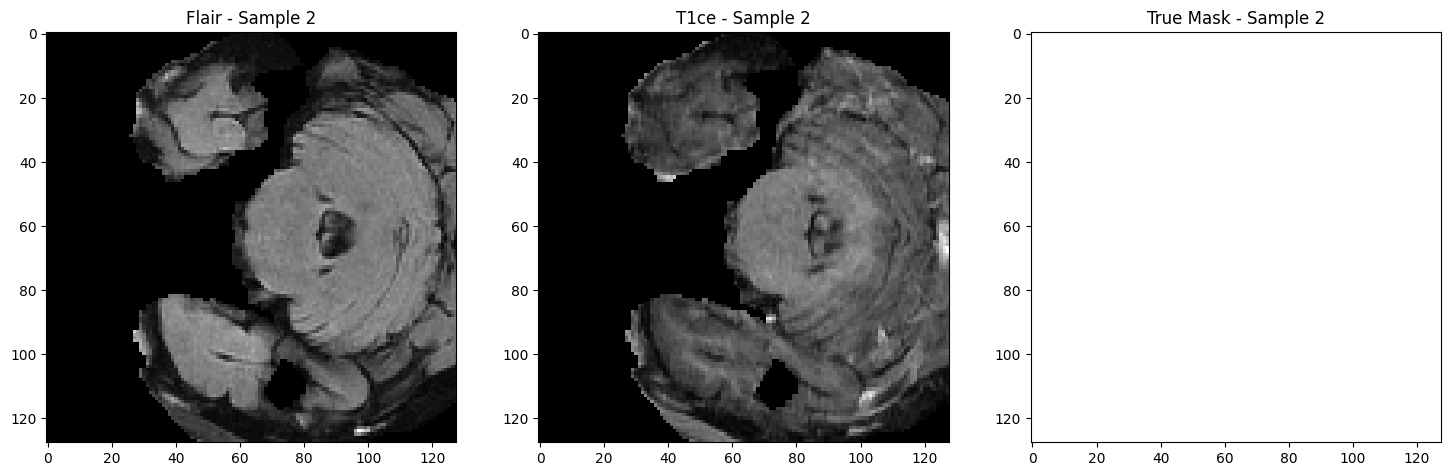

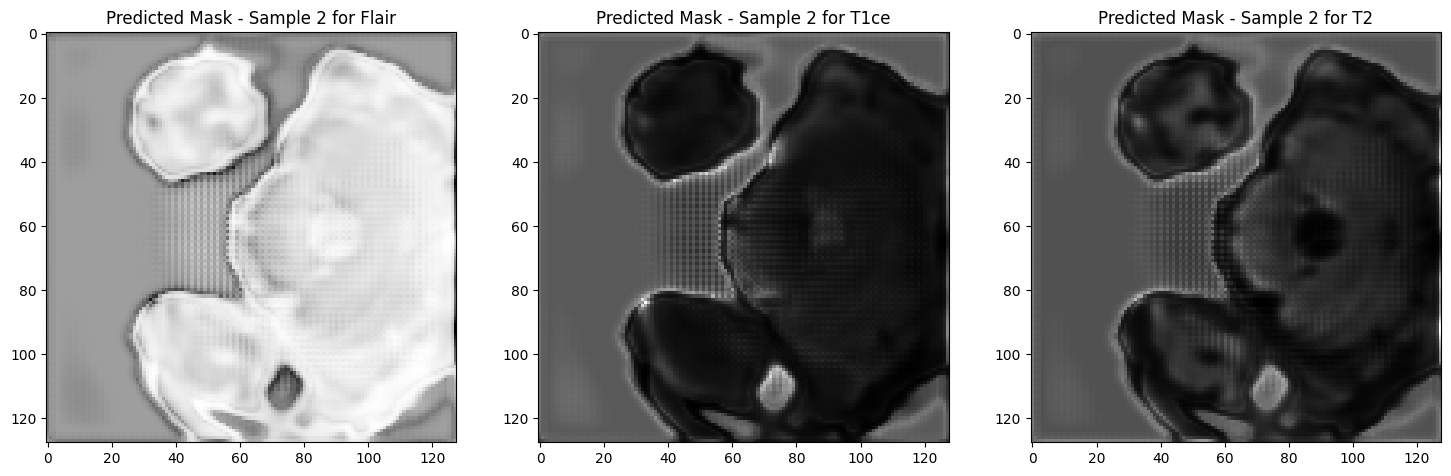

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


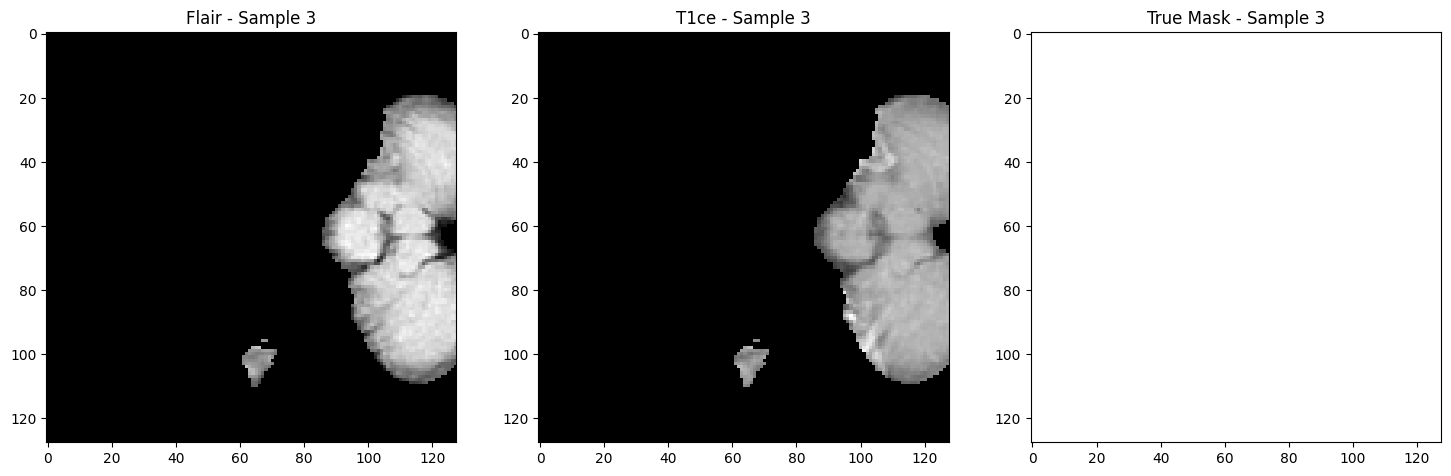

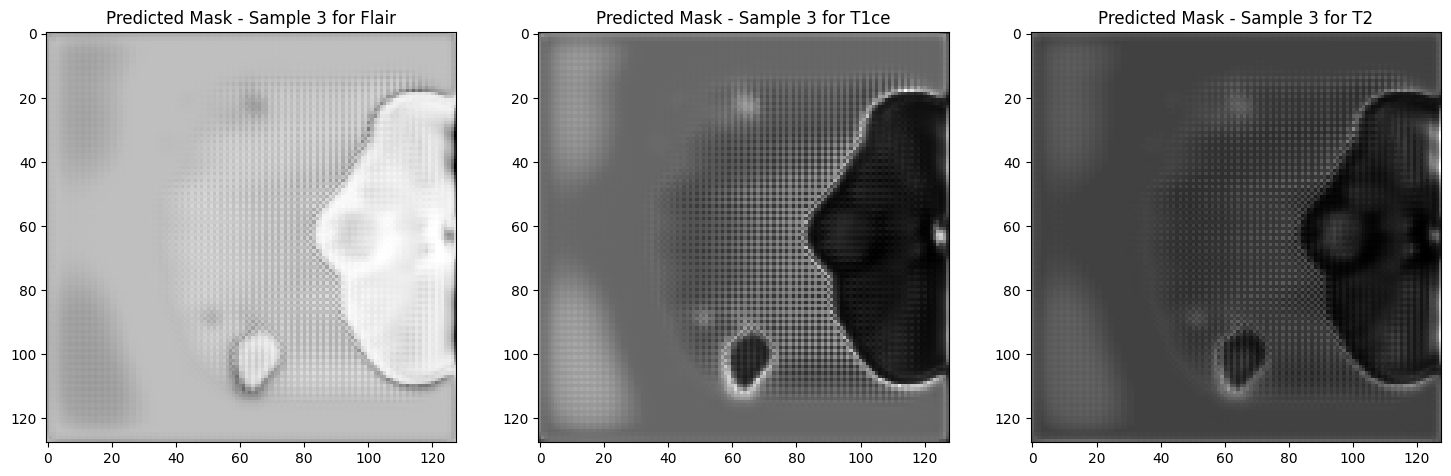

In [83]:
def plot_image_and_mask(val_img_sample, true_mask, predicted_mask, n_slice, sample_idx):
    # Plot the input image slice
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(val_img_sample[:, :, n_slice, 0], cmap='gray')  # Flair
    plt.title(f"Flair - Sample {sample_idx}")

    plt.subplot(1, 3, 2)
    plt.imshow(val_img_sample[:, :, n_slice, 1], cmap='gray')  # T1ce
    plt.title(f"T1ce - Sample {sample_idx}")

    plt.subplot(1, 3, 3)
    plt.imshow(true_mask[:, :, n_slice], cmap='gray')  # True Mask
    plt.title(f"True Mask - Sample {sample_idx}")

    plt.show()

    # Plot the predicted mask
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(predicted_mask[:, :, n_slice, 0], cmap='gray')  # Predicted Mask for Flair
    plt.title(f"Predicted Mask - Sample {sample_idx} for Flair")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask[:, :, n_slice, 1], cmap='gray')  # Predicted Mask for T1ce
    plt.title(f"Predicted Mask - Sample {sample_idx} for T1ce")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[:, :, n_slice, 2], cmap='gray')  # Predicted Mask for T2
    plt.title(f"Predicted Mask - Sample {sample_idx} for T2")

    plt.show()

# Example usage
for i in range(3):  # Plot for 3 samples
    val_index = random.randint(0, X_val.shape[0] - 1)
    val_img_sample = X_val[val_index]
    val_mask_sample = Y_val[val_index]
    predicted_mask = my_model.predict(val_img_sample[np.newaxis, ...])[0]

    n_slice = random.randint(0, val_img_sample.shape[2] - 1)
    plot_image_and_mask(val_img_sample, val_mask_sample, predicted_mask, n_slice, i+1)
